In [121]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import validation_curve
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [13]:
df = pd.read_csv('kc_house_data.csv')

In [55]:
# Convert date to timestamp
df['date'] = pd.to_datetime(df['date'])

In [56]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# 1. Exploratory Data Analysis

First, I'm going to gather some basic information about the data set:

In [57]:
df.shape

(21613, 21)

In [122]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

There are 21,613 house sales in this data set, each of which has 21 features (listed above).

In [59]:
df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

All of the features are numerical, except for the date of the transaction.

## 1.1. Correlation Matrix

In [60]:
df.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
id              -0.016762
zipcode         -0.053203
Name: price, dtype: float64

Looking at the correlation between `price` and the other features, one can notice that the strongest correlation is between price and `sqft_living` (0.7), `grade` (0.67), and `sqft_above` (0.61). Not surprisingly, there is virtually no correlation between `price` and `zipcode`, `id`, and `longitude`.

The following correlation matrix shows the correlation between any two features of the data set.

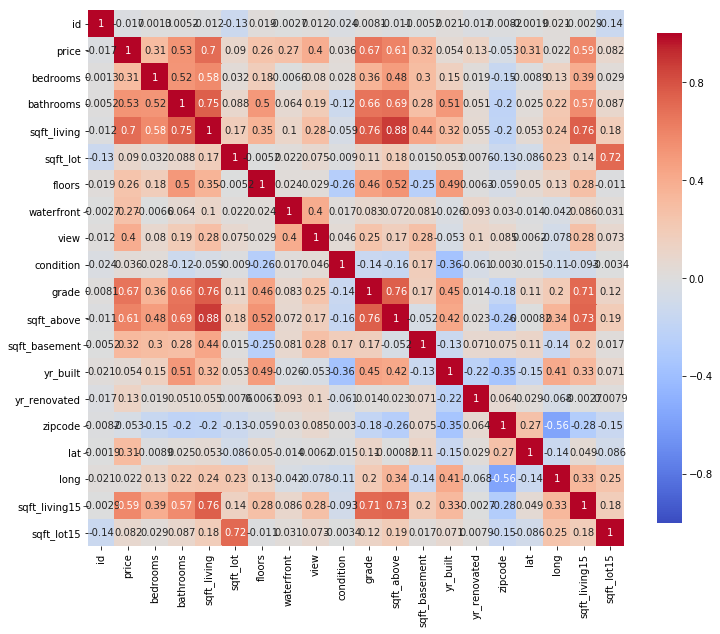

In [61]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),vmax=1.0,vmin=-1.0, square=True,annot=True,cbar_kws={"shrink": .75}, cmap='coolwarm')
plt.show()

In addition to the correlations between `price` and other features, there are some other noteworthy facts about the correlation matrix: the strongest correlation is between `sqft_living` and `sqft_above`, the srongest negative correlation is between `zipcode` and `longitode`, suggesting that zipcodes in King County were drawn from east to west. Generally, there is a strong correlation between the quantities that relate to the size of the house: `sqft_living`, `sqft_living15`, `sqft_above`, `bedrooms`, and `bathrooms`.

# 1.2. House Prices

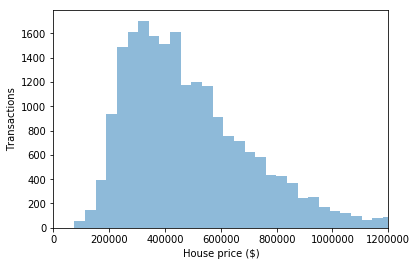

In [54]:
plt.hist(df['price'], bins=200, alpha=0.5)
plt.xlabel('House price ($)')
plt.ylabel('Transactions')
plt.xlim(0,1200000)
plt.show()

In [43]:
print('Mean house price: \t${:0,.2f}'.format(df['price'].mean()))
print('Median house price: \t${:0,.2f}'.format(df['price'].median()))


Mean house price: 	$540,088.14
Median house price: 	$450,000.00


# 2. Pridictive Model for House Prices

In the following, I will build a predictive regression model which will predic the price of a house based on the various features of the house. In order to prepare the data set for model building, the `date` column is transformed into numerical features (year, month, day, and day of the week) and the data are split into a training and a test set. In addition, a standardized feature matrix `X_std` is created.

In [343]:
# Split data into features and target
X = df.drop('price', axis=1)
y = df['price']

# Transform date from single timestamp feature to multiple numerical 
# features
X['date_day'] = X['date'].dt.day
X['date_month'] = X['date'].dt.month
X['date_year'] = X['date'].dt.year
X['date_DoW'] = X['date'].dt.dayofweek
X = X.drop('date', axis=1)

# Split data set into training and test sets
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=0)
    
# Create standardized feature matrix
X_std = StandardScaler().fit_transform(X_train)

## 2.1. Simple Model: Linear Regression

The simplest approach to this regression task is an ordinary least squares regression. I'm using the `LinearRegression` regressor implemented in `scikit-learn`. The performance of the regressor is evaluated by 10-fold cross-validation on the training set using the R2 score as the scoring metric.

In [344]:
# Linear Regression
lr = LinearRegression()

# Evaluate model with cross-validation
cvs = cross_val_score(estimator=lr, X=X_train, 
                                    y=y_train, 
                                    cv=10, scoring='r2')
print('CV score: %.3f ± %.3f' % (cvs.mean(), cvs.std()))

CV score: 0.699 ± 0.017


This simple model achieves an R2 score of 0.70 and we can use the coefficients of the individual features to gain quantiative insights into what affects the pricing of the houses.

In [345]:
lr.fit(X_train, y_train)
coef_list = list(lr.coef_)
name_list = list(X_train.columns)
pd.Series(coef_list, index=name_list)

id                   -0.000001
bedrooms         -34997.381606
bathrooms         39528.155881
sqft_living         112.819757
sqft_lot              0.166812
floors             8015.002050
waterfront       606251.458750
view              52595.525562
condition         27551.746953
grade             93888.181170
sqft_above           72.775118
sqft_basement        40.044639
yr_built          -2604.681249
yr_renovated         21.102001
zipcode            -569.772923
lat              606869.941131
long            -220289.504081
sqft_living15        24.177352
sqft_lot15           -0.478231
date_day           -369.592046
date_month         1359.265288
date_year         38013.762706
date_DoW            465.707124
dtype: float64

According to this model, every square foot of living space adds \$112 to the property value, every bathroom adds \$39,528, and a waterfron view adds \$606,251. While these numbers may sound reasonable, the is cause for scepticism looking at some of the other predictions: it seems counter-intuitive that each bedroom would *reduce* the value by \$34,997 and that the size of the lot has no influence on the pricing.

Since I will be evaluating various regressors in combination with other estimators, the following function is defined as a shortcut to evaluate a model:

In [368]:
def eval_model(estimator, X=X_train, y=y_train, out=True):
    '''
    Evaluates a model provided in 'estimator' and returns the 
    cross-validation score (as a list of 10 results)
    X: Feature matrix
    y: Targets
    '''
    cvs = cross_val_score(estimator=estimator, X=X, y=y, 
                          cv=10, scoring='r2')
    
    if out == True:
        print('CV score: %.3f ± %.3f' % (cvs.mean(), cvs.std()))
    
    return cvs

## 2.2. Feature Selection

In this section I will try to reduce the number of features in order to possibly reduce the effects of overfitting and reduce training time. First, I will build a model with successively more relevant features, second, I will use recursive feature elimination (RFE).

### 2.2.1. Add features according to their correlation with price

The first idea is to start building a very simple model with only one feature, namely the one with the highest correlation with `price`, namely `sqft_living`. Then, more features are added in order of their correlation with `price`. For each model, a score is calculated.

The following code segment produces a `Series` of features and their respective correlations with `price`.

In [330]:
# Calculate correlation or each feature and create sorted 
# pandas Series of correlation factors
corr_ranking = df.corr()['price'].sort_values(ascending=False)[1:]
corr_ranking

sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
id              -0.016762
zipcode         -0.053203
Name: price, dtype: float64

Now, I will loop over the features sorted by correlation and successively add more and more features to the model. At each step, the CV score is calculated and stored in `score_list`. The order in which features were added is stored in `feat_list`.

In [331]:
feat_list = []       # List of features added to the model 
score_list = []      # List of CV scores obtained after adding features

# Loop over features in order of correlation with price
for feat in list(corr_ranking.index):
    
    feat_list.append(feat)      # Add feature name to feat_list
    
    # Calculate CV score
    cvs = eval_model(lr, X=X_train[feat_list], out=False)     
    
    score_list.append(cvs.mean())   # Add score to score_list

The following plot shows the improvement of the model with each new feature added. `sqft_living` along yields a score of 0.49 and the score continuously increases with every feature. There are only a few features that do not inprove the model and none that reduce its score. The contributions of the individual features is indicated by the orange bars.

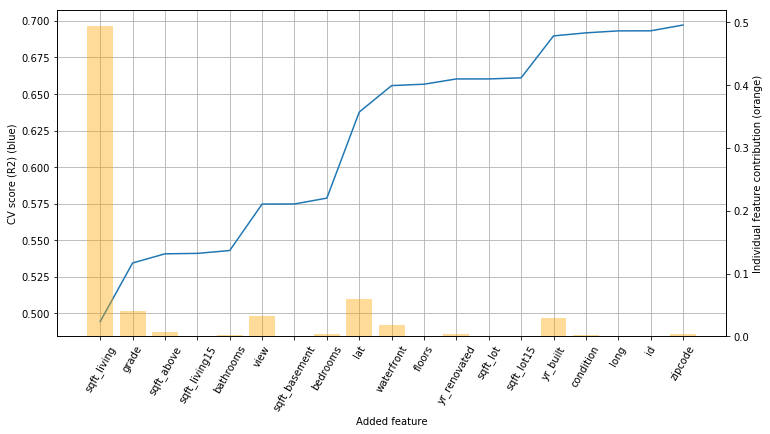

In [332]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

# Accumulated CV score
ax.plot(score_list)
ax.set_xticks(list(range(len(feat_list))))
ax.set_xticklabels(feat_list, rotation=60)
ax.set_xlabel('Added feature')
ax.set_ylabel('CV score (R2) (blue)')
ax.grid()

# Derivative
axR = ax.twinx()
axR.set_ylabel('Individual feature contribution (orange)')
axR.bar(left=list(range(19)), height=np.diff([0]+score_list),
        alpha=0.4, color='orange')

plt.show()

### 2.2.2. Recursive Feature Elimination (RFE)

Next, I will use `scikit-learn`'s RFE implementation to eliminate features in a more sophisticated manner. In the following, RFE is performed for any an increasing number of features to be selected `n` and for each model, the score is recorded in `scores_list`. The below plot shows how the score increases are `n` increases.

In [333]:
features_range = range(1,24)
scores_list = []

for n in features_range:
    rfe = RFE(lr, n, step=1)
    rfe.fit(X_train, y_train)
    scores_list.append(rfe.score(X_train, y_train))

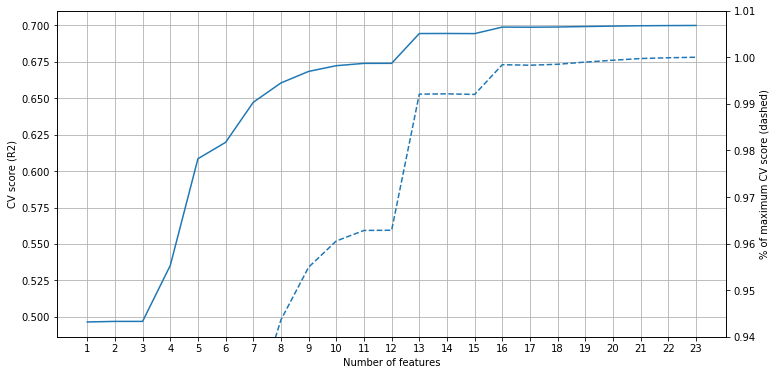

In [334]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

# Regular sized plot
ax.plot(features_range, scores_list)
ax.set_xlabel('Number of features')
ax.set_ylabel('CV score (R2)')
ax.set_xticks(features_range)
ax.grid()

# Vertical magnification
axR = ax.twinx()
axR.plot(features_range, scores_list/max(scores_list), linestyle='--')
axR.set_ylabel('% of maximum CV score (dashed)')
axR.set_ylim(0.94,1.01)

plt.show()

The model's score approaches the maximum value relatively quickly and already after 13 features, the score is above 99% of the final score, meaning that 10 features (almost half) can be discarded without significantly impacting the model accuracy. These are those 13 features:

In [335]:
# Fit RFE model with n_features_to_select=13 to X_train
rfe = RFE(lr, 13, step=1)
rfe.fit(X_train, y_train)

# Print list of selected columns
list(X_train.columns[rfe.support_])

['bedrooms',
 'bathrooms',
 'sqft_living',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'lat',
 'long',
 'date_year']

I'm creating a new feature matrix `X_rfe` containing only the 13 most relevant features.

In [336]:
X_rfe = X_train[list(X_train.columns[rfe.support_])]

## 2.3. Different Regression Algorithms

So far I've only used ordiniary least squares regression, `lr`. The highest score achieved with this model was 0.70.

In [337]:
eval_model(lr, X=X_std);

CV score: 0.699 ± 0.015


### 2.3.1. Ridge

Ridge regression is an alternative to ordinary least squares regression, the main difference being that large coefficients are penalized in this model. The strength of this regularization is determined by the hyperparameter `alpha`. With the default of `alpha`=1.0, ridge regression yields the same R2 score:

In [263]:
ridge = linear_model.Ridge()
eval_model(ridge, X=X_std);

CV score: 0.699 ± 0.017


In the following, a validation curve is used to determine whether other parameters of `alpha` yield improved scores. As the plot below shows, this is not the case. In fact, the model score seems independent of `alpha`, except for values exceeding 1,000 for which the model quickly deteriorates.

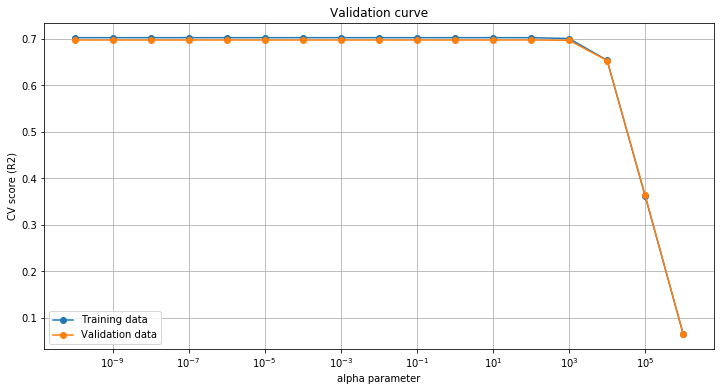

In [254]:
# Trying different alpha parameters for Ridge regression

test_int = np.logspace(-10, 6, 17)

train_scores, valid_scores = \
            validation_curve(ridge, X_std, y_train, 'alpha',
                                test_int, cv=5)

# Plot validation curve
plt.figure(figsize=(12,6))
plt.title('Validation curve')
plt.semilogx(test_int, np.mean(train_scores, axis=1), 
             marker='o', label='Training data')
plt.semilogx(test_int, np.mean(valid_scores, axis=1), 
             marker='o', label='Validation data')
plt.legend()
plt.ylabel('CV score (R2)')
plt.xlabel('alpha parameter')
plt.grid()
plt.show()

### 2.3.2. Lasso

The same behavior (and no improvement in the R2 score) is observed for regression with lasso (L1) regularization. This is likely due to the relatively small number of features.

In [266]:
lasso = linear_model.Lasso()
eval_model(lasso, X=X_std);

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

CV score: 0.699 ± 0.017


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


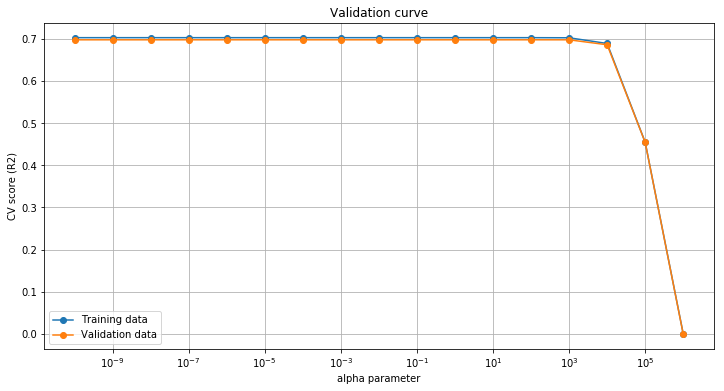

In [267]:
# Trying different alpha parameters for Lasso regression

test_int = np.logspace(-10, 6, 17)

train_scores, valid_scores = \
            validation_curve(lasso, X_std, y_train, 'alpha',
                                test_int, cv=5)

# Plot validation curve
plt.figure(figsize=(12,6))
plt.title('Validation curve')
plt.semilogx(test_int, np.mean(train_scores, axis=1), 
             marker='o', label='Training data')
plt.semilogx(test_int, np.mean(valid_scores, axis=1), 
             marker='o', label='Validation data')
plt.legend()
plt.ylabel('CV score (R2)')
plt.xlabel('alpha parameter')
plt.grid()
plt.show()

### 2.3.3. SVR

Another alternative regression model is Support Vector Regression (SVR), which in this case proves much worse than the linear model:

In [269]:
svr = SVR(kernel='linear', C=1)
eval_model(svr, X=X_std);

CV score: 0.088 ± 0.015


array([0.06641412, 0.07501845, 0.09492012, 0.09126587, 0.08698766,
       0.07740102, 0.11327185, 0.07698808, 0.07872636, 0.1146053 ])

### 2.3.4. Random Forest Regressor

On the other hand, the Random Forest Regressor proves the most accurate model with an R2 score of 0.72, however this comes at the substantial computational cost. The random forest regressor takes over 400 times longer, although using the reduced feature set `X_rfe`, the computation takes less than half as long.

In [274]:
forest = RandomForestRegressor(max_depth=4, random_state=0,
                              n_estimators=200)
eval_model(forest, X=X_std);

CV score: 0.721 ± 0.020


In [277]:
%timeit eval_model(lr, X=X_std, out=False)

197 ms ± 42.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [278]:
%timeit eval_model(forest, X=X_std, out=False)

1min 23s ± 7.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [279]:
%timeit eval_model(forest, X=X_rfe, out=False)

33.4 s ± 97.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 2.4. Feature Engineering

After having investigated options to eliminate irrelevant features above, I will now create additional features that improve the quality of the model.

### 2.4.1. Add polynomial features

Using `sciki-learn`'s `PolynomialFeatures()`, I am expanding the feature matrix by quadratic and cubic terms. This improves the model quality to a score of 0.81 in case of polynomial order 2 and a standardized input matrix.

In [338]:
# Second order (quadratic) polynomials with linear regression
pipe = Pipeline([('poly', PolynomialFeatures(2)),
                 ('lr', lr)])

In [339]:
eval_model(pipe, X=X_train); # quadratic terms, unstandardized features

CV score: 0.738 ± 0.029


In [340]:
eval_model(pipe, X=X_std);   # quadratic terms, standardized features

CV score: 0.815 ± 0.019


In [295]:
# Third order (cubic) polynomials with linear regression
pipe = Pipeline([('poly', PolynomialFeatures(3)),
                 ('lr', lr)])

In [296]:
eval_model(pipe, X=X_train);

KeyboardInterrupt: 

Training the model on a feature matrix containing cubic terms increases the training time substantially. Therefore, I will try to reduce the number of features in the following by using RFE to reduce the size of the feature matrix before adding cubic terms. However, this model does not yield useful predictions.

In [304]:
pipe = Pipeline([('rfe', RFE(lr, 13, step=1)),
                 ('poly', PolynomialFeatures(3)),
                 ('lr', lr)])
eval_model(pipe, X=X_std);

CV score: -1.912 ± 8.104


### 2.4.3. Combine polynomial features with PCA

In this section, the size of the feature matrix will be reduced not through RFE before adding cubic terms, but using principal component analysis (PCA). First, I will train a linear regression model on the PCA-reduced feature matrix alone. Not surprisingly, this reduces the score:

In [341]:
pipe = Pipeline([('pca', PCA(n_components=13)),
                 ('lr', lr)])
eval_model(pipe, X=X_std);

CV score: 0.662 ± 0.021


Now, I'm adding cubic terms after reducing the feature matrix size. The combination of PCA and cubic terms yields a score of 0.77 which is significantly better than the score of the linear model alone.

In [372]:
pipe = Pipeline([('std1', StandardScaler()),
                 ('pca1', PCA(n_components=11)),
                 ('poly1', PolynomialFeatures(3)),
                 ('lr', lr)])
eval_model(pipe, X=X_train);

CV score: 0.764 ± 0.032
